<a href="https://colab.research.google.com/github/ChelseaOwiti/Colposcopy-Scan/blob/main/draft1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading Dataset and Splitting into train, val, test**

In [1]:
%cd /content/drive/MyDrive/Project
%ls

/content/drive/MyDrive/Project
assets/      data/         h5_model.h5        logs/         saved_model.pb
d2_model.h5  draft1.ipynb  imagenet_model.h5  model.tflite  variables/
d3_model.h5  draft2.ipynb  keras_metadata.pb  output/


In [2]:
trainpath = 'data/train'
valpath = 'data/val'
testpath = 'data/test'

In [3]:
import numpy as np
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

import pathlib

In [4]:
train_dir = pathlib.Path(trainpath)
test_dir = pathlib.Path(valpath)

print(str(len(list(train_dir.glob('*/*.jpg'))) )+ ' Training Images')
print(str(len(list(test_dir.glob('*/*.jpg')))) + ' Testing Images')

888 Training Images
296 Testing Images


In [5]:
batch_size = 32  
img_height = 224
img_width = 224

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.1,
    subset ='training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 888 files belonging to 3 classes.
Using 800 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.1,
    subset ='validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 888 files belonging to 3 classes.
Using 88 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Type_1', 'Type_2', 'Type_3']


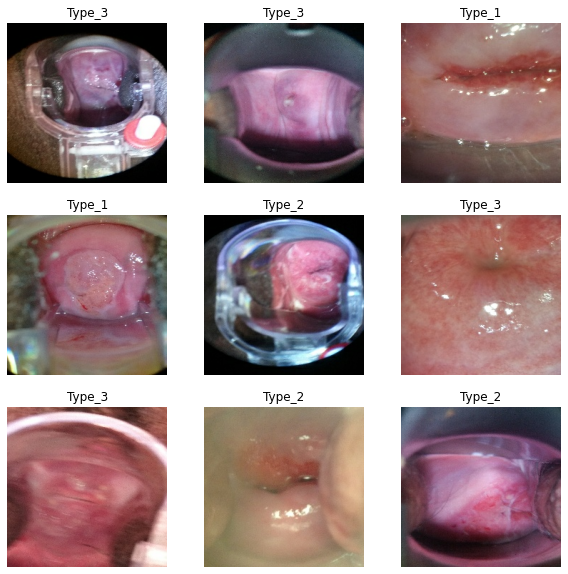

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [10]:
for image_batch, labels_batch in train_ds: #image batch is a tensor of the shape
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.003921569 1.0


**Training a basic keras model**

In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
25/25 [==============================] - 30s 883ms/step - loss: 1.3402 - accuracy: 0.4825 - val_loss: 0.9855 - val_accuracy: 0.5682
Epoch 2/10
25/25 [==============================] - 1s 33ms/step - loss: 1.0091 - accuracy: 0.5225 - val_loss: 0.9973 - val_accuracy: 0.5682
Epoch 3/10
25/25 [==============================] - 1s 33ms/step - loss: 0.9829 - accuracy: 0.5325 - val_loss: 0.9675 - val_accuracy: 0.5909
Epoch 4/10
25/25 [==============================] - 1s 33ms/step - loss: 0.9329 - accuracy: 0.5275 - val_loss: 0.9560 - val_accuracy: 0.5795
Epoch 5/10
25/25 [==============================] - 1s 33ms/step - loss: 0.8824 - accuracy: 0.5875 - val_loss: 0.9723 - val_accuracy: 0.6023
Epoch 6/10
25/25 [==============================] - 1s 33ms/step - loss: 0.8335 - accuracy: 0.6012 - val_loss: 1.0239 - val_accuracy: 0.4432
Epoch 7/10
25/25 [==============================] - 1s 33ms/step - loss: 0.7427 - accuracy: 0.6612 - val_loss: 1.0150 - val_accuracy: 0.4773
Epoch 8/10


**Visualize training results**

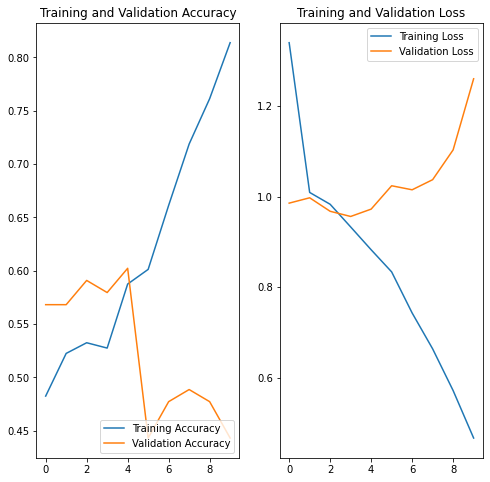

In [17]:
#plots for accuracy on training and validation sets
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model is overfitting, this can be seen from the vast difference in training and validation accuracy

**Data Augmentation**

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

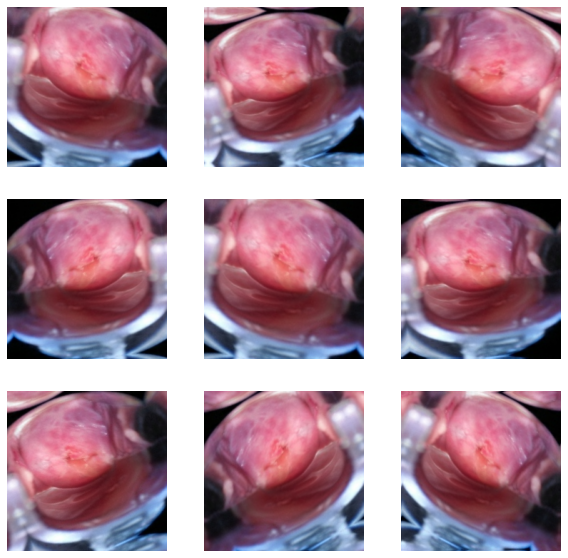

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Trying drop out technique to reduce overfitting

In [20]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [23]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
25/25 [==============================] - 2s 56ms/step - loss: 1.5002 - accuracy: 0.4963 - val_loss: 0.9940 - val_accuracy: 0.5682
Epoch 2/15
25/25 [==============================] - 1s 51ms/step - loss: 0.9948 - accuracy: 0.5500 - val_loss: 1.0007 - val_accuracy: 0.4659
Epoch 3/15
25/25 [==============================] - 1s 49ms/step - loss: 0.9447 - accuracy: 0.5575 - val_loss: 0.9455 - val_accuracy: 0.5227
Epoch 4/15
25/25 [==============================] - 1s 50ms/step - loss: 0.9263 - accuracy: 0.5400 - val_loss: 0.9198 - val_accuracy: 0.5909
Epoch 5/15
25/25 [==============================] - 1s 49ms/step - loss: 0.8800 - accuracy: 0.5775 - val_loss: 0.9642 - val_accuracy: 0.5114
Epoch 6/15
25/25 [==============================] - 1s 50ms/step - loss: 0.8886 - accuracy: 0.5800 - val_loss: 0.9292 - val_accuracy: 0.5455
Epoch 7/15
25/25 [==============================] - 1s 51ms/step - loss: 0.8876 - accuracy: 0.5638 - val_loss: 0.9384 - val_accuracy: 0.5227
Epoch 8/15
25

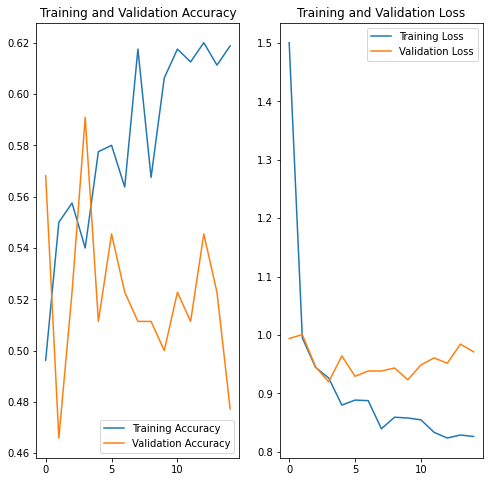

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Making predictions

In [30]:
test_image = '/content/drive/MyDrive/Project/data/val/Type_1/171.jpg'

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 15ms/step
This image most likely belongs to Type_2 with a 75.07 percent confidence.


In [31]:
test_image = '/content/drive/MyDrive/Project/data/val/Type_2/1010.jpg'

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 15ms/step
This image most likely belongs to Type_2 with a 64.23 percent confidence.


In [32]:
test_image = '/content/drive/MyDrive/Project/data/val/Type_3/1029.jpg'

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 16ms/step
This image most likely belongs to Type_3 with a 53.37 percent confidence.


In [33]:
model.save("draft1_model.h5")